# Imports

In [2]:
import os
os.chdir('../../vlm_toolbox/')

/home/heydari/hierarchy


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import ast
import gc
import random
import warnings

import networkx as nx
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, Markdown, display
from cuml import TSNE
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from torchvision import transforms, transforms as T
from transformers import (
    ImageFeatureExtractionMixin,
    OwlViTForObjectDetection,
    OwlViTProcessor,
)

from config.annotations import AnnotationsConfig
from config.enums import (
    CLIPBackbones,
    DataStatus,
    Granularities,
    ImageDatasets,
    Modalities,
    Setups,
    Sources,
    Stages,
    Trainers,
)
from config.image_datasets import ImageDatasetConfig
from config.metric import MetricIOConfig
from config.model import ModelConfigManager
from config.setup import Setup
from data.data_access.image_factory import ImageHandlerFactory
from data.data_access.label_factory import LabelHandleFactory
from data.data_access.text_factory import TextHandlerFactory
from libs.transformer_mm_cam import transformer_mm_runner
from metric.accuracy import AccuracyMetricEvaluator
from model.vlm_factory import VLMFactory
from util.networkx_helper import create_nx_graph, find_smallest_subtree
from util.pandas_helper import show_df
from util.torch_helper import torch_decorator


os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings('ignore')

# Config

### Device

In [64]:
DEVICE_TYPE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(DEVICE_TYPE)
DEVICE

device(type='cuda')

### Data Type

In [65]:
ENABLE_FP16 = True
dtype = torch.float16 if ENABLE_FP16 else torch.float32

### Training

In [66]:
PREPROCESS_BATCH_SIZE = 512
RANDOM_STATE = 42

### Setup

In [8]:
setup = Setup(
    setup=Setups.FEW_SHOT,
    metric_for_best_model=AccuracyMetricEvaluator.get_main_metric_name(),
    dataset_name=ImageDatasets.IMAGENET_1K,
    backbone_name=CLIPBackbones.CLIP_VIT_B_16,
    trainer_name=Trainers.COOP,
    source=Sources.OPEN_AI,
    granularity=Granularities.FINE,
    n_shots=16,
)
setup

Setup(setup='few_shot', dataset_name='imagenet1k', backbone_name='clip_vit_b_16', source='open_ai', trainer_name='coop', granularity='fine', metric_for_best_model='top_1', n_shots=16, is_supervised=True, is_soft=True)

### Data

In [9]:
IMAGE_MODALITY_TYPE = DataStatus.RAW
SPLIT = Stages.EVAL

In [10]:
HIERARCHY_LABELS_PATH = f'./annotations/{setup.dataset_name}/hierarchy_labels.csv'
EDGE_INDEX_PATH = f'./annotations/{setup.dataset_name}/edges.csv'
COARSE_LABEL_NAME = 'coarse'

In [11]:
CHECKPOINT_PATH = None

In [12]:
EXPERIMENT_STRINGIFIED_TIME = '2024_05_03__11'
METRICS_DIRECTORY = MetricIOConfig.get_config(setup) + EXPERIMENT_STRINGIFIED_TIME

OVERALL_PATH = METRICS_DIRECTORY + '/overall.csv'
PER_CLASS_PATH = METRICS_DIRECTORY + '/per_class.csv'
PER_SAMPLE_PATH = METRICS_DIRECTORY + '/per_sample.csv'

In [13]:
SOFT_PROMPT_GROUP = None

In [14]:
annotations_config = AnnotationsConfig.get_config(dataset_name=setup.dataset_name)
image_dataset_config = ImageDatasetConfig.get_config(
    setup,
    split=SPLIT,
    data_type=IMAGE_MODALITY_TYPE,
)

# Labels Loading

In [15]:
label_handler = (
    LabelHandleFactory.create_from_config(annotations_config)
    .set_prompt_mode(is_soft=setup.is_soft)
    .config_prompts(soft_prompt_group=SOFT_PROMPT_GROUP)
).show()

labels = label_handler.get_labels()
metadata_df = label_handler.get_metadata_df()
prompts_df = label_handler.get_prompts_df()
labels_df = label_handler.labels_df
class_ids = label_handler.get_class_ids()
class_id_label_id_adj_matrix = label_handler.get_class_id_label_id_adj_matrix()
label_id_prompt_id_mapping = label_handler.get_label_id_prompt_id_mapping()

Current label column: simplified
Number of classes: 1000
Number of labels: 1000
Prompt mode: Soft
Soft prompt group: generic
Number of soft prompts: 1
Dataset's prompt context initialization: it is an image of


# Model Loading

In [16]:
model_config = ModelConfigManager.get_config(
    backbone_name=setup.backbone_name,
    source=setup.source,
    trainer_name=setup.trainer_name,
    labels=labels,
    label_id_prompt_id_mapping=label_id_prompt_id_mapping,
)

vlm = VLMFactory.from_pretrained(model_config=model_config).to(DEVICE).eval()
if CHECKPOINT_PATH:
    vlm.load_state_dict(torch.load(CHECKPOINT_PATH))
vlm.show()

Initializing 1 prompt contexts randomely.
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
coop - clip_vit_b_16
Total model parameters: 124332033
🔥 Trainable model parameters: 8192 (0.01%)
🧊 Frozen model parameters: 124323841 (99.99%)

Attribute Name: model, Type: CustomCLIP, Param Share: 100.00%:
-    Attribute Name: prompt_learner, Type: PromptLearner, Param Share: 0.01%:
--       🔥 Trainable: 100.00%, 🧊 Frozen: 0.00%
-    Attribute Name: image_encoder, Type: VisionTransformer, Param Share: 69.32%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%
-    Attribute Name: text_encoder, Type: TextEncoder, Param Share: 30.67%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%

Device: cuda:0
Model size: 357.382MB
Logit scale: 100.0000
Modalities @ VALIDATION

M1: Modality(modality_type='image', identifier='class_id', raw_keys=['image'], preprocessed_keys={'input': ['image'], 'output': ['pixel_values']}, embedding_key='{'input': ['pixel_values'], 'output': [

# Util

In [79]:
def flush():
    gc.collect()
    torch.cuda.empty_cache()
    
def construct_labels_graph(labels_df, edges_df, sample_dict, top_predictions_df, to_prune_roots_cnt=0):
    nx_graph = create_nx_graph(labels_df, edges_df)
    prediction_idxs = top_predictions_df['idx'].tolist()
    
    all_subgraph_idxs = list(set(prediction_idxs + [sample_dict['idx']]))
    sub_graph = find_smallest_subtree(nx_graph, all_subgraph_idxs, to_prune_roots_cnt)

    node_dict = {}
    for idx in list(sub_graph.nodes()):
        label_row = labels_df[labels_df['idx'] == idx].iloc[0]
        inner_dict = {'label': label_row['label'], 'probability': 0.0, 'color': 'lightblue', 'size': 50}
        node_dict[idx] = inner_dict
        
    for _, row in top_predictions_df.iterrows():
        idx = row['idx']
        if idx == sample_dict['idx']:
            continue
        rank = row['rank']
        color = 'green' if row['is_correct'] else 'red'
        inner_dict = {'label': row['label'] + f'Top-{rank}', 'probability': row['probability'], 'color': color, 'size': 150}
        node_dict[idx] = inner_dict

   
    node_dict[sample_dict['idx']] = {'label': sample_dict['label'] + ' GT', 'probability': sample_dict.get('probability', 0.0), 'color': 'green', 'size': 200,}
    nx.set_node_attributes(sub_graph, values=node_dict, name='attribute')
    return nx_graph, sub_graph

def visualize_graph(graph , coordinates=None):
    plt.figure(figsize=(10, 5))
    if coordinates:
        pos = coordinates
    else:
        pos = graphviz_layout(graph, prog="dot")
        pos = {node: (x,-y) for (node, (x,y)) in pos.items()}
    
    labels = {}
    color_map = []
    node_size = []
    node_ids = list(graph.nodes)
    
    for node_id in node_ids:
        attribute = graph.nodes[node_id].get('attribute', {})
        color_map.append(attribute['color'])
        node_size.append(attribute['size'])
        label = attribute['label']
        labels[node_id] = label
        
    nx.draw(graph, pos, with_labels=True, node_color=color_map, edge_color='gray', labels=labels, node_size=node_size, arrows=True, font_size=8)
    green_line = plt.scatter([], [], color='green', label='Actual Label')
    red_line = plt.scatter([], [], color='red', label='Predicted Label')

    plt.legend(handles=[green_line, red_line])
    plt.axis('off')
    plt.show()


def plot_tsne_labels_with_predictions_graph(latent_text_embs, predictions_df, top_predictions_df, sample_dict, sub_G=None, show_hierarchy=False):
    plt.figure(figsize=(20, 13))
    filtered_node_ids = set(top_predictions_df['idx']).union([sample_dict['idx']])
    filtered_predictions_df = predictions_df[~predictions_df['idx'].isin(filtered_node_ids)]

    filtered_coords = latent_text_embs[filtered_predictions_df['idx']]
    top_coords = latent_text_embs[top_predictions_df['idx']]
    sample_coords = latent_text_embs[sample_dict['idx']]

    plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], color='black', s=10, alpha=0.1)

    for (x, y), (index, row) in zip(top_coords, top_predictions_df.iterrows()):
        plt.scatter(x, y, color='black', s=100)
        plt.annotate(f'Top-{index+1}\n{row["label"]}', (x, y), fontsize=12, color='red')

    plt.scatter(sample_coords[0], sample_coords[1], color='green', s=100)
    plt.annotate(f'Actual\n{sample_dict["label"]}', (sample_coords[0], sample_coords[1]), fontsize=12, color='green')

    if show_hierarchy:
        for u, v in sub_G.edges():
            u_coords = latent_text_embs[u]
            v_coords = latent_text_embs[v]
    
            dx, dy = v_coords[0] - u_coords[0], v_coords[1] - u_coords[1]
            plt.arrow(u_coords[0], u_coords[1], dx, dy, color='blue', alpha=0.6, length_includes_head=True, head_width=0.1, head_length=0.2)  # Draw arrow
                
            # plt.plot([u_coords[0], v_coords[0]], [u_coords[1], v_coords[1]], color='blue')  # Draw line
            u_label = sub_G.nodes[u]['attribute']['label']
            v_label = sub_G.nodes[v]['attribute']['label']
            plt.text(u_coords[0], u_coords[1], s=u_label, color='blue', fontsize=10)  # Label node u
            plt.text(v_coords[0], v_coords[1], s=v_label, color='blue', fontsize=10)  # Label node v

    plt.title('t-SNE with Text Labels, Predictions')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

def printmd(string, color=None):
    colorstr = "<b><span style='color:{}'>{}</span></b>".format(color, string)
    display(Markdown(colorstr))

def visualize_text_attention(tokens, values, title, title_color):
    def rgb_to_hex(rgb):
        return '#%02x%02x%02x' % rgb
        
    def attention2color(attention_score):
        r = 255 - int(attention_score * 255)
        color = rgb_to_hex((r, r, 255))
        return str(color)


    html_text = f"<hr><p style='font-size: large'><b><span style='color:{title_color}'>{title}:</span></b>  <br>"
    previous_token = ""
    for token, attention in zip(tokens, values):
        if previous_token and not previous_token.endswith(' '):
            html_text = html_text.strip() + "<span style='background-color:{};'>{}<span> ".format(attention2color(attention), token)
        else:
            html_text += "<span style='background-color:{};'>{}<span> ".format(attention2color(attention), token)
        previous_token = token
    html_text += "</p>"
    return html_text

def plot_img(ax, img, title=''):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

def cast_df_string_to_list(df):
    def convert_string_to_list(s):
        try:
            if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
                return ast.literal_eval(s)
            return s
        except (ValueError, SyntaxError):
            return s

    for column in df.columns:
        if df[column].apply(lambda x: isinstance(x, str) and x.startswith('[') and x.endswith(']')).any():
            df[column] = df[column].apply(convert_string_to_list)
    return df

### Image Dataset

In [18]:
image_dataset_handler = (
    ImageHandlerFactory.create_from_config(
        Modalities.M1,
        image_dataset_config,
    )
).show()

Dataset({
    features: ['image', 'class_id'],
    num_rows: 50000
})

Identifier column name: class_id
Value column names: ['image']

Modality(modality_type='image', identifier='class_id', raw_keys=['image'], preprocessed_keys={'input': ['image'], 'output': ['pixel_values']}, embedding_key='{'input': ['pixel_values'], 'output': ['image_embeds']}', status='raw', requires_grad=False, requires_preprocess=True)


### Text Dataset

In [19]:
text_dataset_handler = TextHandlerFactory.create_from_df(
    Modalities.M2,
    SPLIT,
    prompts_df,
    annotations_config,
).show()

Dataset({
    features: ['label_id', 'label'],
    num_rows: 1000
})

Identifier column name: label_id
Value column names: ['label_id']

Modality(modality_type='text', identifier='label_id', raw_keys=['label_id'], preprocessed_keys={'input': ['label'], 'output': ['input_ids']}, embedding_key='{'input': ['label_id'], 'output': ['text_embeds']}', status='raw', requires_grad=False, requires_preprocess=False)


### Edges Data

In [20]:
kg_edges_df = cast_df_string_to_list(pd.read_csv(EDGE_INDEX_PATH))
hierarchy_labels_df = cast_df_string_to_list(pd.read_csv(HIERARCHY_LABELS_PATH))
show_df(kg_edges_df, head=5)

shape: (9707, 4)


label       parent_label  idx  parent_idx
0               [physical_entity]           [entity]    1           0
1  [abstraction, abstract_entity]           [entity]    2           0
2                         [thing]           [entity]    3           0
3     [process, physical_process]  [physical_entity]    4           1
4       [object, physical_object]  [physical_entity]    5           1

# Sample Analysis

In [21]:
N_WORST_COARSE_GRAINED, N_WORST_FINE_GRAINED = 3, 30
TOP_N_PREDICTIONS = 5
TOP_N_VISUALIZE = 5

clip_pil_preprocess = transforms.Compose([
    T.ToTensor(),
    T.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None),
    T.CenterCrop(size=(224, 224)),
    T.ToPILImage(),
])

clip_normalizing_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [22]:
fine_grained_acc_df = (
    pd.read_csv(PER_CLASS_PATH)
)
top_k_columns = list(fine_grained_acc_df.columns)[1:]
fine_grained_acc_df = (
    fine_grained_acc_df
    .merge(
        metadata_df[['class_id', COARSE_LABEL_NAME]],
        on='class_id',
        how='left',
    )
)
fine_grained_acc_df['coarse_id'], _ = pd.factorize(fine_grained_acc_df[COARSE_LABEL_NAME])
coarse_grained_acc_df = (
    fine_grained_acc_df.groupby(['coarse_id', ])[[*top_k_columns]]
    .mean().reset_index().sort_values('coarse_id', inplace=False)
)

In [23]:
show_df(fine_grained_acc_df)

shape: (1000, 8)


class_id  top_1_accuracy  top_2_accuracy  top_3_accuracy  top_4_accuracy  \
0         0            0.90            0.96            0.98            1.00   
1         1            1.00            1.00            1.00            1.00   
2         2            0.86            0.92            0.98            0.98   
3         3            0.78            0.90            0.94            0.96   
4         4            0.68            0.84            0.98            0.98   

   top_5_accuracy coarse  coarse_id  
0            1.00   fish          0  
1            1.00   fish          0  
2            0.98  shark          1  
3            0.96  shark          1  
4            1.00  shark          1

In [24]:
show_df(coarse_grained_acc_df)

shape: (67, 6)


coarse_id  top_1_accuracy  top_2_accuracy  top_3_accuracy  top_4_accuracy  \
0          0        0.729231        0.856923        0.910769        0.936923   
1          1        0.820000        0.910000        0.975000        0.980000   
2          2        0.870847        0.941356        0.962373        0.972203   
3          3        0.628000        0.880000        0.924000        0.948000   
4          4        0.553333        0.893333        0.926667        0.946667   

   top_5_accuracy  
0        0.953846  
1        0.985000  
2        0.977627  
3        0.964000  
4        0.946667

In [75]:
per_sample_prediction_df = pd.read_csv(PER_SAMPLE_PATH, index_col=False).reset_index(drop=False).rename(columns={'index': 'dataset_idx'})
per_sample_prediction_df['idx'] = per_sample_prediction_df['class_id'].apply(
    lambda class_id: hierarchy_labels_df[hierarchy_labels_df['class_id'] == class_id].iloc[0].idx,
)
show_df(per_sample_prediction_df)

shape: (50000, 15)


dataset_idx  class_id actual_label_ids  correct_pred_rank  pred@1_label_id  \
0            0         0              [0]                  2              394   
1            1         0              [0]                  1                0   
2            2         0              [0]                  1                0   
3            3         0              [0]                  1                0   
4            4         0              [0]                  1                0   

   pred@1_prob  pred@2_label_id  pred@2_prob  pred@3_label_id  pred@3_prob  \
0     0.495626                0     0.342515              389     0.060947   
1     0.956863              389     0.030872              758     0.010495   
2     0.851235              758     0.087714              389     0.033815   
3     0.992967              389     0.003908              758     0.001010   
4     0.985287              389     0.014132              758     0.000179   

   pred@4_label_id  pred@4_prob  pred@5_label_id  pred@5_prob   idx  
0              395     0.041020              391     0.032449  9624  
1              392     0.000606              600     0.000240  9624  
2              395     0.012520              693     0.002961  9624  
3              395     0.000699              390     0.000348  9624  
4              395     0.000147              390     0.000060  9624

In [26]:
complemented_labels_df = (
    hierarchy_labels_df.copy()
    .merge(
        labels_df[['class_id', 'class_label', 'label']],
        on='class_id',
        how='left', 
    )
)

show_df(complemented_labels_df)

shape: (9708, 15)


idx      wn_id                          labels parent_wn_id  \
0    0  n00001740                        [entity]          NaN   
1    1  n00001930               [physical_entity]    n00001740   
2    2  n00002137  [abstraction, abstract_entity]    n00001740   
3    3  n04424418                         [thing]    n00001740   
4    4  n00029677     [process, physical_process]    n00001930   

       parent_labels                                    children_wn_ids  \
0                 []                  [n00002137, n00001930, n04424418]   
1           [entity]  [n00007347, n00020827, n00002684, n00029677, n...   
2           [entity]  [n00024264, n00033020, n00031264, n00033615, n...   
3           [entity]  [n03005920, n03395745, n03537866, n03599212, n...   
4  [physical_entity]  [n13445972, n13455906, n13458571, n13460299, n...   

                                     children_labels  depth  \
0  [[abstraction, abstract_entity], [physical_ent...      0   
1  [[causal_agent, cause, causal_agency], [matter...      1   
2  [[attribute], [communication], [group, groupin...      1   
3  [[change], [freshener], [horror], [jimdandy, j...      1   
4  [[chelation], [dealignment], [decrease, decrem...      2   

                                         description  class_id simplified  \
0  that which is perceived or known or inferred t...        -1        NaN   
1              an entity that has physical existence        -1        NaN   
2  a general concept formed by extracting common ...        -1        NaN   
3           an entity that is not named specifically        -1        NaN   
4  a sustained phenomenon or one marked by gradua...        -1        NaN   

  keras coarse-grained class_label label  
0   NaN            NaN         NaN   NaN  
1   NaN            NaN         NaN   NaN  
2   NaN            NaN         NaN   NaN  
3   NaN            NaN         NaN   NaN  
4   NaN            NaN         NaN   NaN

In [27]:
class SampleHandler:
    def __init__(
        self,
        image_dataset,
        labels_df=labels_df,
        per_sample_prediction_df=per_sample_prediction_df,
        fine_acc_df=fine_grained_acc_df,
        coarse_acc_df=coarse_grained_acc_df,
        complemented_labels_df=complemented_labels_df,
        random_state=RANDOM_STATE,
    ):
        self.image_dataset = image_dataset
        self.labels_df=labels_df
        self.per_sample_prediction_df = per_sample_prediction_df
        self.fine_acc_df = fine_acc_df
        self.coarse_acc_df = coarse_acc_df
        self.complemented_labels_df = complemented_labels_df
        
    def sample(self, cnt=N_WORST_FINE_GRAINED, based_on='top_1_accuracy', ascending=True, random_state=None):
        sampled_classes = self.fine_acc_df.sort_values(
            by=based_on,
            ascending=ascending
        ).head(n=cnt)

        sampled_validatoin_instance = (
            self.per_sample_prediction_df[self.per_sample_prediction_df['class_id']
            .isin(sampled_classes.class_id.tolist())]
            .sample(n=1, random_state=random_state)
        ).iloc[0].to_dict()

        complimentory_info = (
            self.complemented_labels_df[self.complemented_labels_df['class_id'] == sampled_validatoin_instance['class_id']]
        ).iloc[0].to_dict()
        sampled_validatoin_instance['label'] = complimentory_info['label']
        image_dataset_row = self.image_dataset[sampled_validatoin_instance['dataset_idx']]
        sampled_validatoin_instance.update(image_dataset_row)
        sampled_validatoin_instance.update(complimentory_info)
        for key in list(sampled_validatoin_instance.keys()):
            if key.startswith('pred@') and key.endswith('_label_id'):
                label_id = sampled_validatoin_instance[key]
                label_row = self.labels_df.loc[self.labels_df['label_id'] == label_id].iloc[0]
                label, class_id = label_row.label, label_row.class_id
                idx = self.complemented_labels_df[self.complemented_labels_df['class_id'] == class_id].iloc[0].idx
                new_key = key.replace('_label_id', '_label')
                sampled_validatoin_instance[key.replace('_label_id', '_label')] = label
                sampled_validatoin_instance[key.replace('_label_id', '_idx')] = idx

        prediction_keys = [key for key in sampled_validatoin_instance.keys() if key.startswith('pred@')]
        num_predictions = len(set(key.split('_')[0] for key in prediction_keys))
        predictions = []
        for i in range(1, num_predictions + 1):
            pred_info = {}
            pred_info['rank'] = i
            pred_info['probability'] = sampled_validatoin_instance[f'pred@{i}_prob']
            pred_info['label_id'] = sampled_validatoin_instance[f'pred@{i}_label_id']
            pred_info['idx'] = sampled_validatoin_instance[f'pred@{i}_idx']
            pred_info['label'] = sampled_validatoin_instance[f'pred@{i}_label']
            pred_info['is_correct'] = (sampled_validatoin_instance['correct_pred_rank'] == i)
            predictions.append(pred_info)
        
        top_predictions_df = pd.DataFrame(predictions)
        return sampled_validatoin_instance, top_predictions_df

In [28]:
query_template = 'this is an image of {}'

sample_handler = SampleHandler(image_dataset_handler.get_dataset())
sample_dict, top_predictions_df = sample_handler.sample()
sample_img = sample_dict.pop('image')
sample_label = sample_dict.get('label')
top_predictions_df

rank  probability  label_id   idx             label  is_correct
0     1     0.240290       676  3820            muzzle       False
1     2     0.102836       188  8479  Wire Fox Terrier       False
2     3     0.086639       157  7697          Papillon       False
3     4     0.074560       192  7674     Cairn Terrier       False
4     5     0.043901       199  7600  Scottish Terrier       False

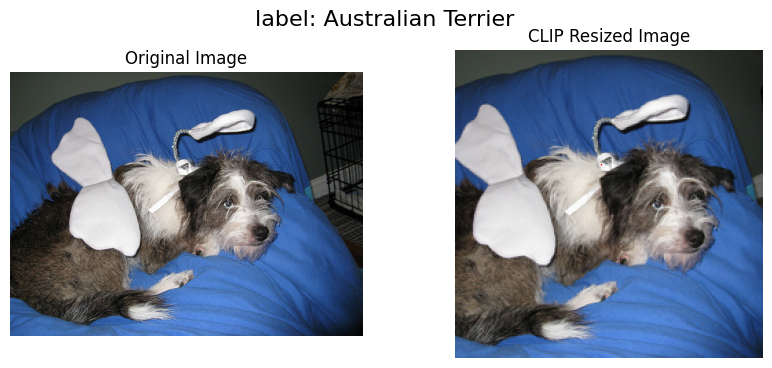

{'dataset_idx': 5276,
 'class_id': 193,
 'actual_label_ids': '[193]',
 'correct_pred_rank': -1,
 'pred@1_label_id': 676,
 'pred@1_prob': 0.2402900159358978,
 'pred@2_label_id': 188,
 'pred@2_prob': 0.102836012840271,
 'pred@3_label_id': 157,
 'pred@3_prob': 0.0866393893957138,
 'pred@4_label_id': 192,
 'pred@4_prob': 0.0745604336261749,
 'pred@5_label_id': 199,
 'pred@5_prob': 0.0439008437097072,
 'label': 'Australian Terrier',
 'idx': 7743,
 'wn_id': 'n02096294',
 'labels': ['Australian_terrier'],
 'parent_wn_id': 'n02092468',
 'parent_labels': ['terrier'],
 'children_wn_ids': [],
 'children_labels': [],
 'depth': 11,
 'description': 'small greyish wire-haired breed of terrier from Australia similar to the cairn',
 'simplified': 'Australian Terrier',
 'keras': 'Australian terrier',
 'coarse-grained': 'dog',
 'class_label': 'Australian Terrier',
 'pred@1_label': 'muzzle',
 'pred@1_idx': 3820,
 'pred@2_label': 'Wire Fox Terrier',
 'pred@2_idx': 8479,
 'pred@3_label': 'Papillon',
 'pred@

In [29]:
clip_sample_img = clip_pil_preprocess(sample_img)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_img(axs[0], sample_img, 'Original Image')
plot_img(axs[1], clip_sample_img, 'CLIP Resized Image')
fig.suptitle(f'label: {sample_label}', fontsize=16)
plt.show()
sample_dict

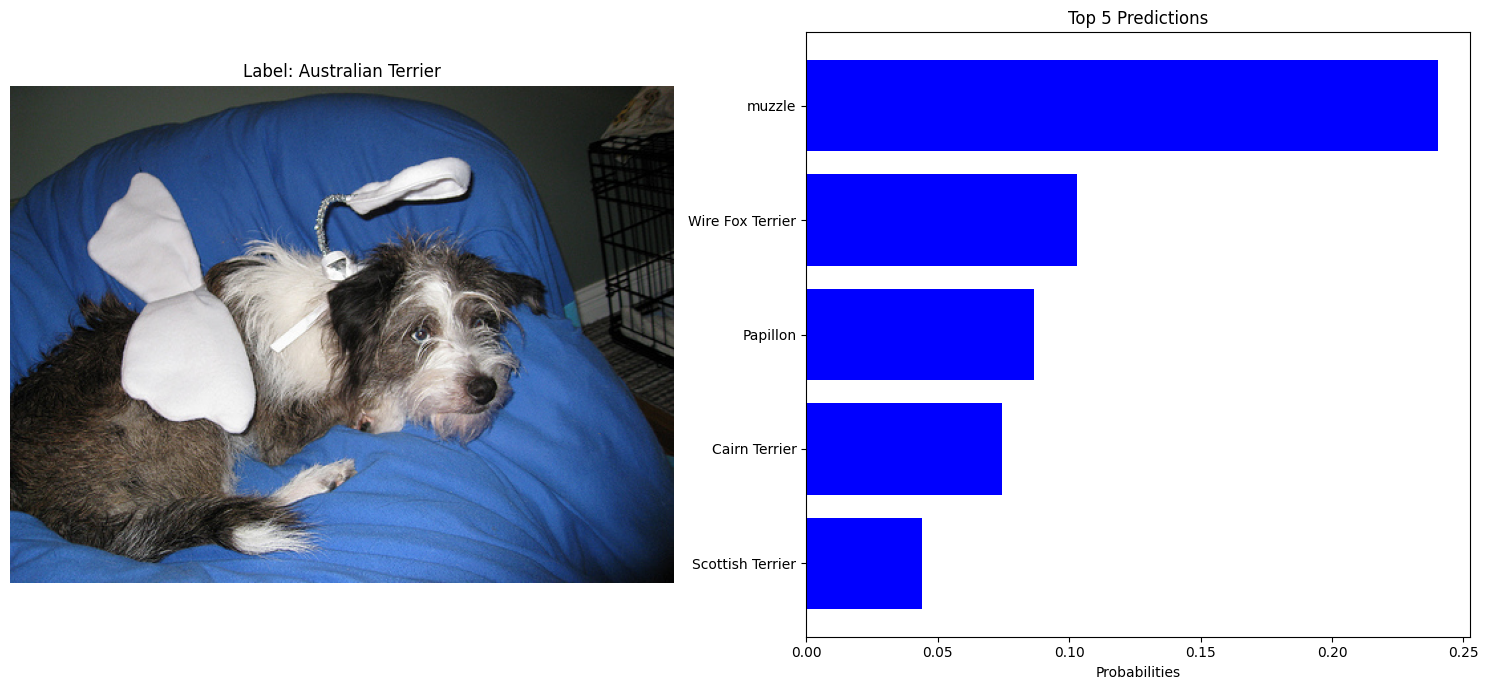

In [30]:
def plot_clip_top_predictions(sample_img, sample_dict, top_predictions_df):
    label = sample_dict.get('label')
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].imshow(sample_img)
    axs[0].set_title(f'Label: {label}')
    axs[0].axis('off')
    axs[1].barh(top_predictions_df['label'], top_predictions_df['probability'], color='blue')
    axs[1].set_xlabel('Probabilities')
    axs[1].set_title(f'Top {top_predictions_df.shape[0]} Predictions')
    axs[1].invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_clip_top_predictions(sample_img, sample_dict, top_predictions_df)

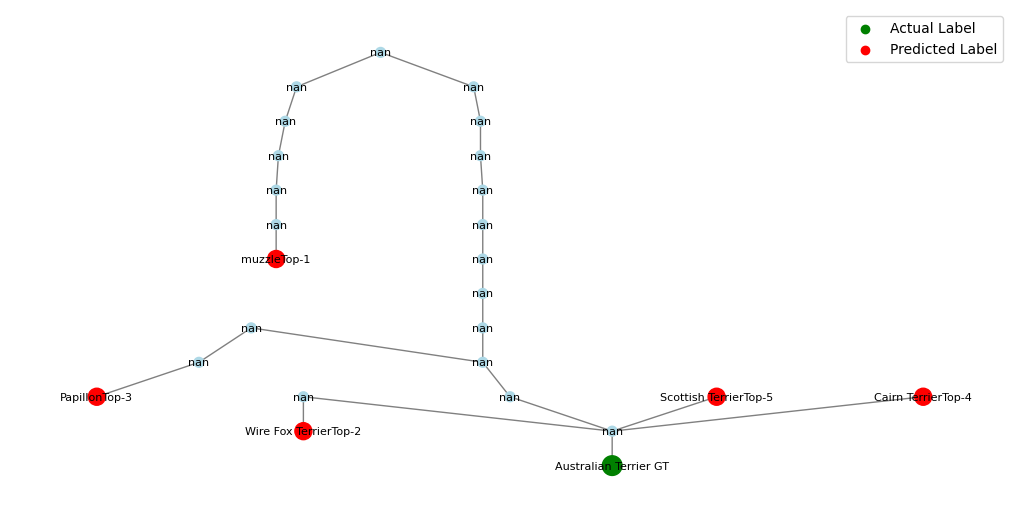

In [31]:
nx_graph, sub_graph = construct_labels_graph(complemented_labels_df, kg_edges_df, sample_dict, top_predictions_df, to_prune_roots_cnt=3)
visualize_graph(sub_graph)

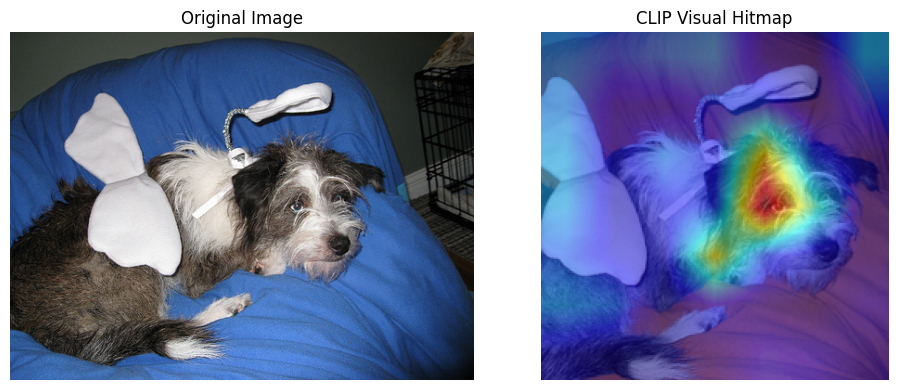

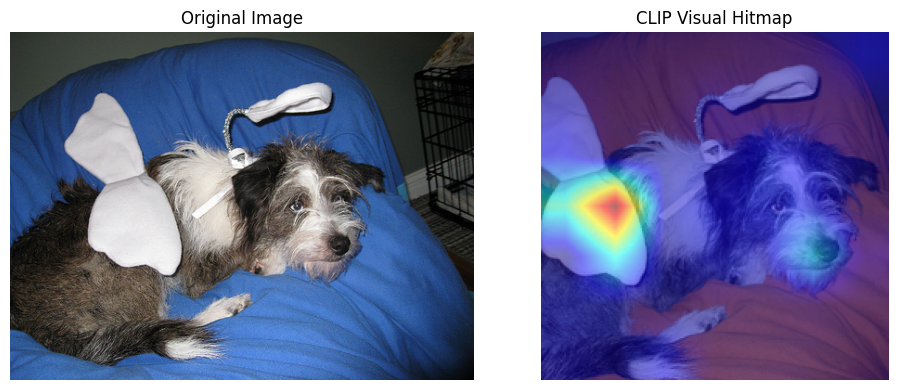

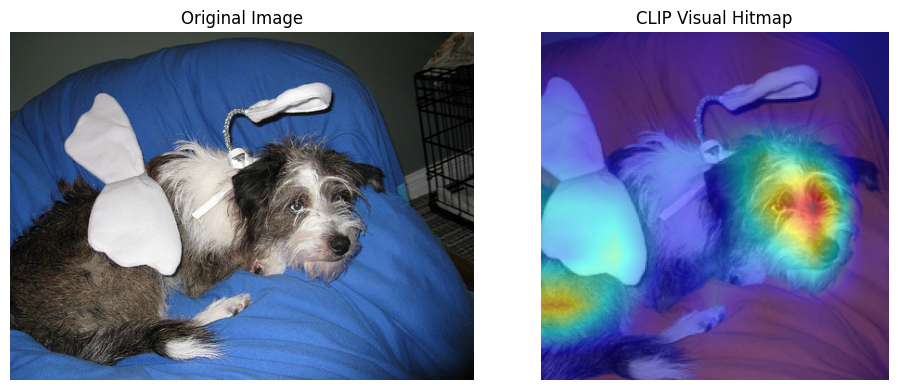

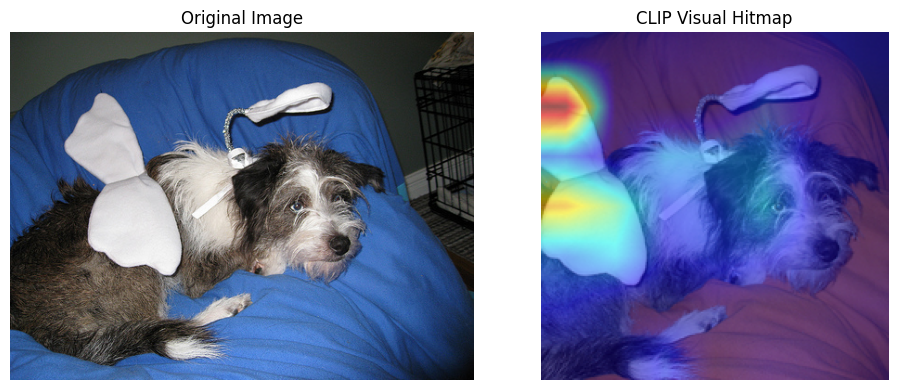

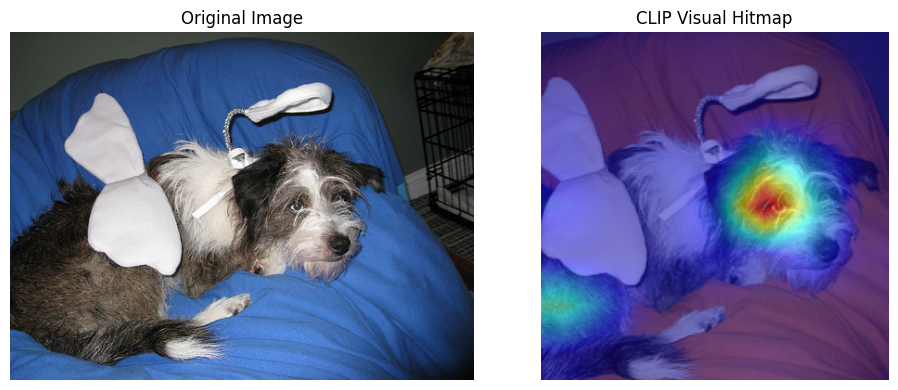

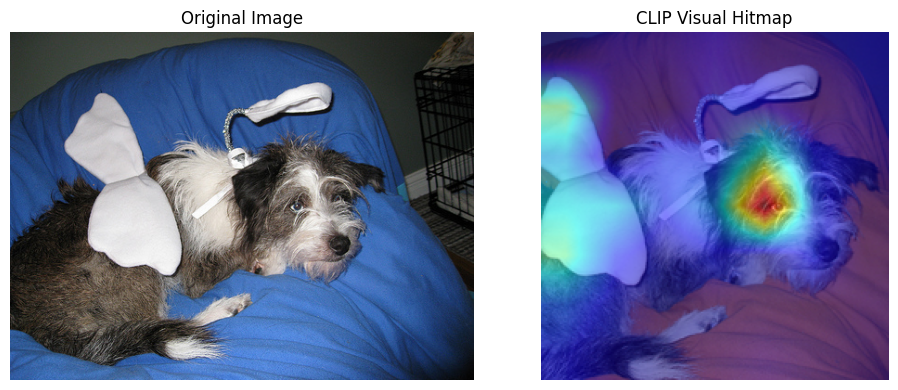

In [32]:
def visualize_heatmaps(gt_prompt, prediction_prompts, image_pil, image_pt, device=DEVICE):
    prompts = [gt_prompt] + prediction_prompts
    vision_heatmaps, prompt_heatmaps = transformer_mm_runner.visualize_gradcam(image_pt, image_pil, prompts, device) 
    for i, prompt in enumerate(prompts):
        token, values = list(zip(*prompt_heatmaps[i]))
        if i == 0:
            html_text = visualize_text_attention(token, values, f'Ground Truth Prompt', 'green')
        else:
            html_text = visualize_text_attention(token, values, f'Top-{i} False Prediction Prompt', 'red')
        
        display(HTML(html_text))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        
        plot_img(axs[0], image_pil, 'Original Image')
        plot_img(axs[1], vision_heatmaps[i], 'CLIP Visual Hitmap')
        plt.subplots_adjust(wspace=0.)
        plt.tight_layout()
        plt.show()
        print()

gt_prompt = query_template.format(sample_dict['label'])
prediction_prompts = [query_template.format(x) for x in top_predictions_df['label'].tolist()]

visualize_heatmaps(gt_prompt, prediction_prompts, sample_img, vlm.preprocess_image([sample_img])['pixel_values'].squeeze())

In [52]:
complemented_text_dataset_handler = (
    TextHandlerFactory.create_from_df(
        Modalities.M2,
        SPLIT,
        cast_df_string_to_list(complemented_labels_df),
        {},
    )
    .set_identifier('idx')
    .apply_transformation(
        transform_fn=lambda row: {'label_id': row['idx'], 'label': row['simplified'] if row['class_id'] != -1 else row['labels'][0]},
        source_col_names=['idx', 'class_id', 'simplified', 'labels'],
        keep_source_cols=True,
        batched=False,
        in_place=True,
    )
)

Map:   0%|          | 0/9708 [00:00<?, ? examples/s]

In [37]:
complemented_model_config = ModelConfigManager.get_config(
    backbone_name=setup.backbone_name,
    source=setup.source,
    trainer_name=setup.trainer_name,
    labels=complemented_text_dataset_handler.dataset['label'],
    label_id_prompt_id_mapping=torch.zeros(len(complemented_text_dataset_handler.dataset)),
)

complemented_vlm = VLMFactory.from_pretrained(model_config=complemented_model_config).to(DEVICE).eval()

complemented_vlm.model.prompt_learner.ctx = vlm.model.prompt_learner.ctx
complemented_vlm.show()

Initializing 1 prompt contexts randomely.
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
coop - clip_vit_b_16
Total model parameters: 124332033
🔥 Trainable model parameters: 8192 (0.01%)
🧊 Frozen model parameters: 124323841 (99.99%)

Attribute Name: model, Type: CustomCLIP, Param Share: 100.00%:
-    Attribute Name: prompt_learner, Type: PromptLearner, Param Share: 0.01%:
--       🔥 Trainable: 100.00%, 🧊 Frozen: 0.00%
-    Attribute Name: image_encoder, Type: VisionTransformer, Param Share: 69.32%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%
-    Attribute Name: text_encoder, Type: TextEncoder, Param Share: 30.67%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%

Device: cuda:0
Model size: 1400.008MB
Logit scale: 100.0000
Modalities @ VALIDATION

M1: Modality(modality_type='image', identifier='class_id', raw_keys=['image'], preprocessed_keys={'input': ['image'], 'output': ['pixel_values']}, embedding_key='{'input': ['pixel_values'], 'output': 

In [53]:
with torch.no_grad(), torch.autocast(device_type=DEVICE_TYPE, dtype=dtype):
    complemented_vlm.eval()
    complemented_text_dataset_handler.to_embedding(
        transform_fn=complemented_vlm.get_embedding_fn_for_modality(complemented_text_dataset_handler.modality),
        batch_size=PREPROCESS_BATCH_SIZE,
    )
    flush()


Map:   0%|          | 0/9708 [00:00<?, ? examples/s]

In [57]:
node_embeds = complemented_text_dataset_handler.get_dataset()['text_embeds'].numpy()
node_embeds_tsne = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(node_embeddings)
node_embeds_tsne_df = pd.DataFrame(node_embeds_tsne, columns=['tsne1', 'tsne2'])

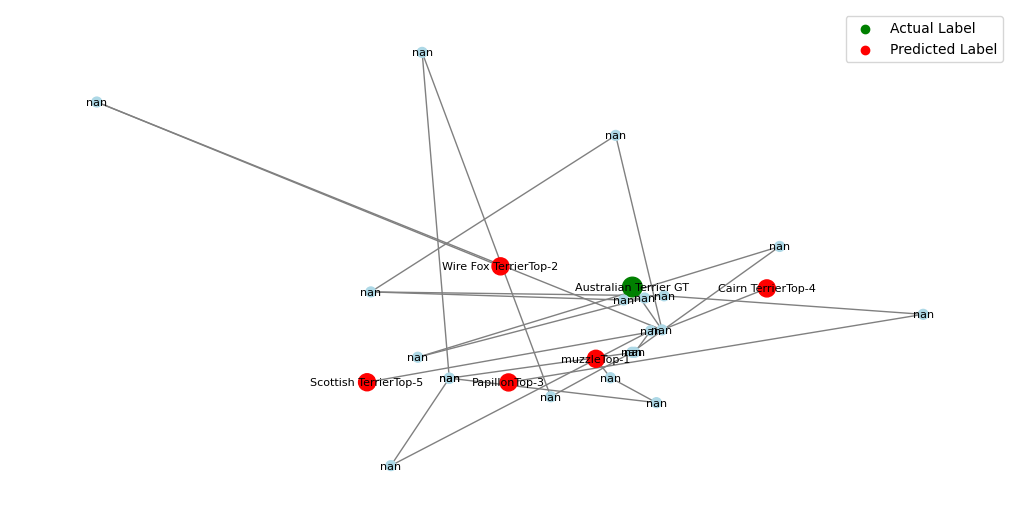

In [58]:
tsne_subgraph_coordinates = {node_id: (node_embeds_tsne[i][0], node_embeds_tsne[i][1]) for i, node_id in enumerate(sub_graph.nodes)}
visualize_graph(sub_graph, coordinates=tsne_subgraph_coordinates)

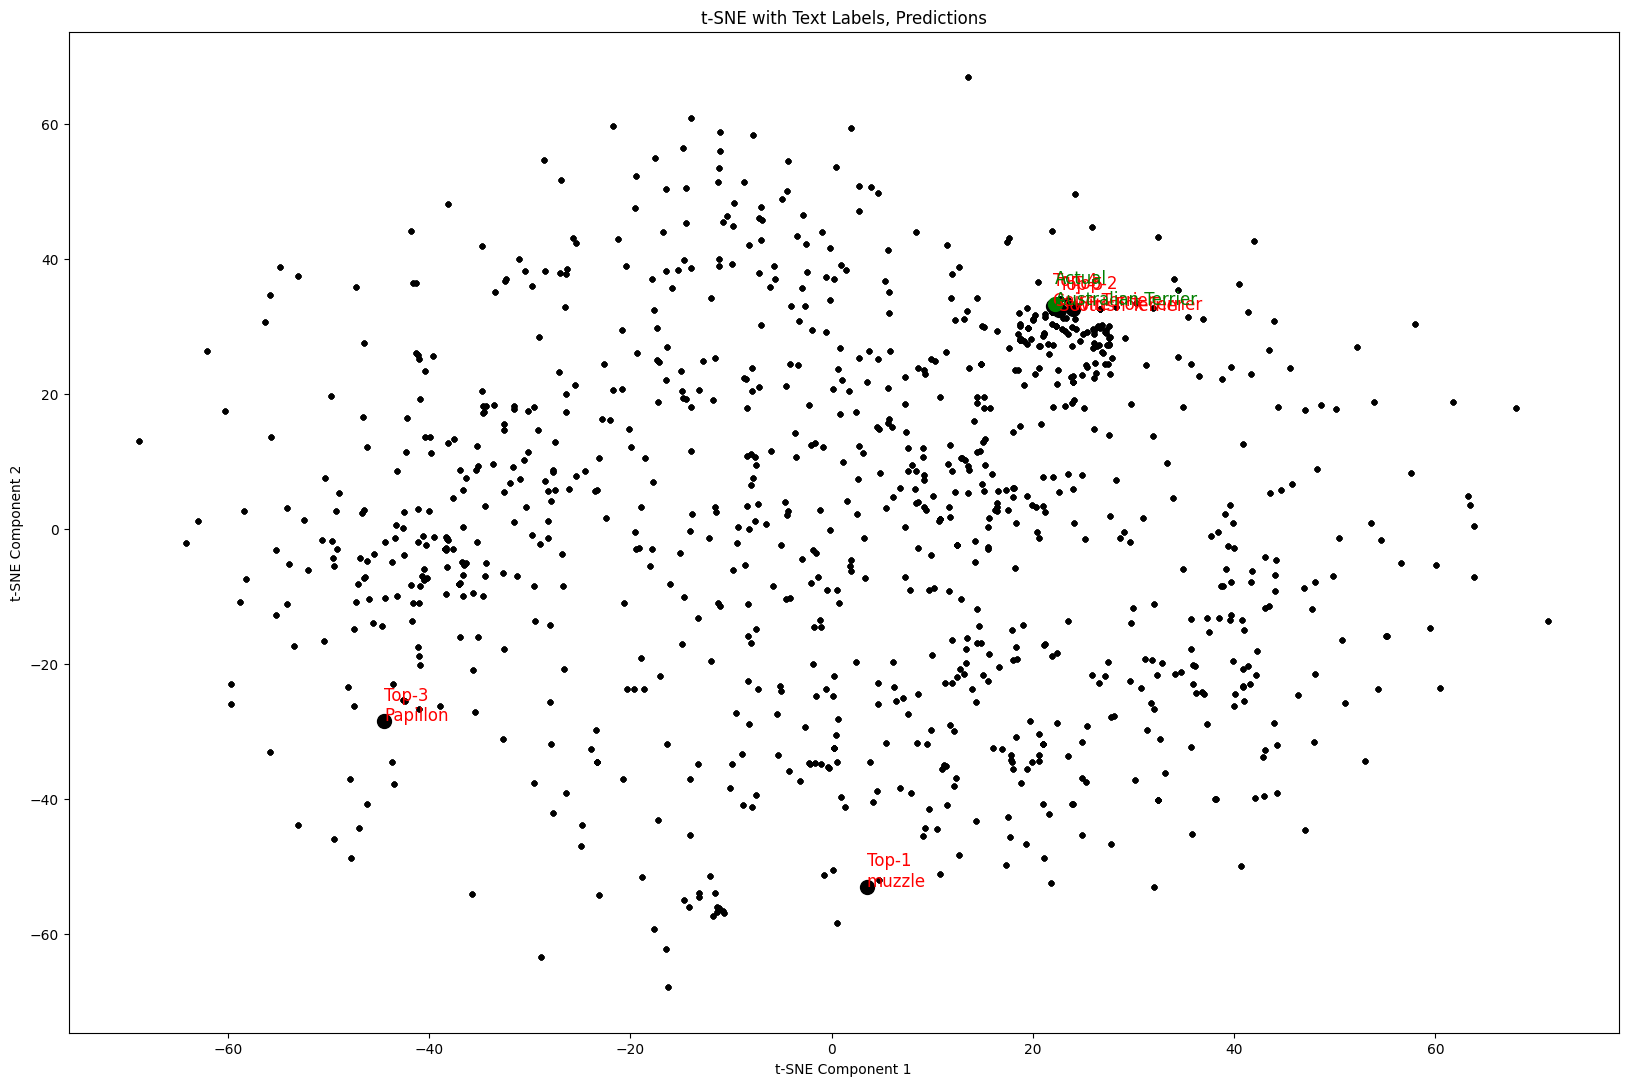

In [80]:
plot_tsne_labels_with_predictions_graph(node_embeds_tsne, per_sample_prediction_df, top_predictions_df, sample_dict, sub_graph, show_hierarchy=False)

## Zero-shot Object Detection Analysis

In [81]:
@torch_decorator(no_grad=True)
def visualize_zero_shot_object_detection_boxes(sample_img, queries, title, device=DEVICE):
    pretrained_od = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)
    pretrained_od.eval()

    pretrained_od_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
    inputs = pretrained_od_processor(text=queries, images=sample_img, return_tensors="pt").to(device)
    outputs = pretrained_od(**inputs)

    mixin = ImageFeatureExtractionMixin()
    
    image = mixin.resize(sample_img,  pretrained_od.config.vision_config.image_size)
    input_image = np.asarray(image).astype(np.float32) / 255.0
    
    score_threshold = 0.1
    
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
        if score < score_threshold:
            continue

        cx, cy, w, h = box
        ax.plot(
            [cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
            [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2],
            "r",
        )
        text_x = random.choice([cx-w/2, cx+w/2])
        text_y = random.choice([cy-h/2-0.015, cy-h/2+0.015, cy+h/2-0.015, cy+h/2+0.015])
        ax.text(text_x, text_y, f"{queries[label]}: {score:1.2f}", ha="left", va="top", color="red",
            bbox={
                "facecolor": "white",
                "edgecolor": "red",
                "boxstyle": "square,pad=.3"
            },
        )
    plt.title(title)
    plt.show()
    return boxes

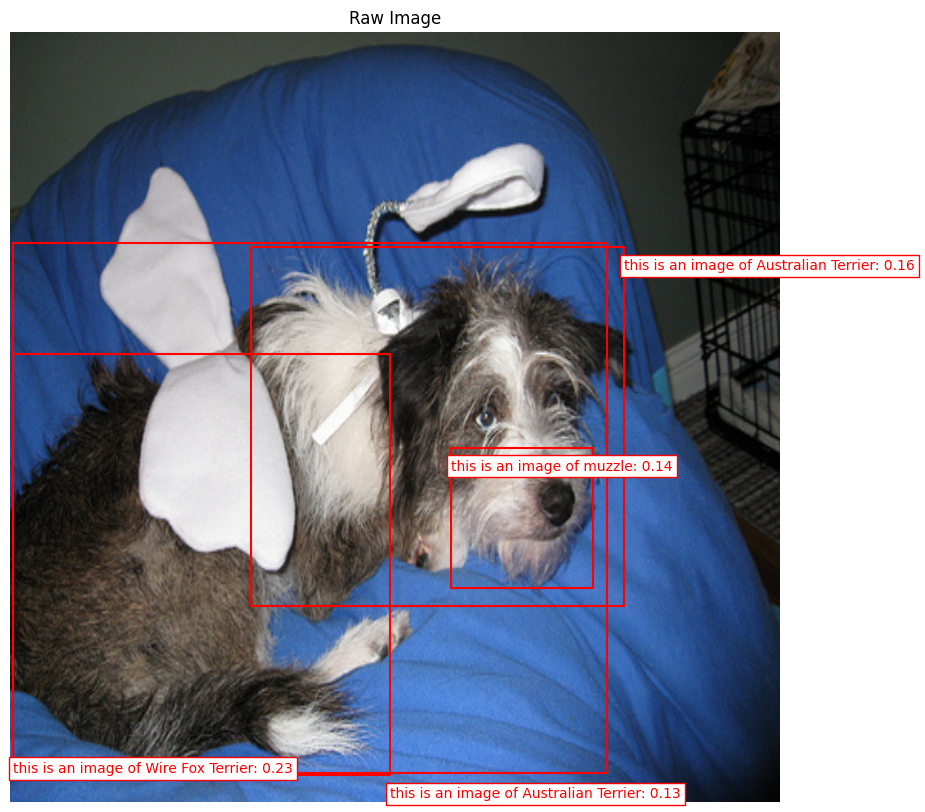

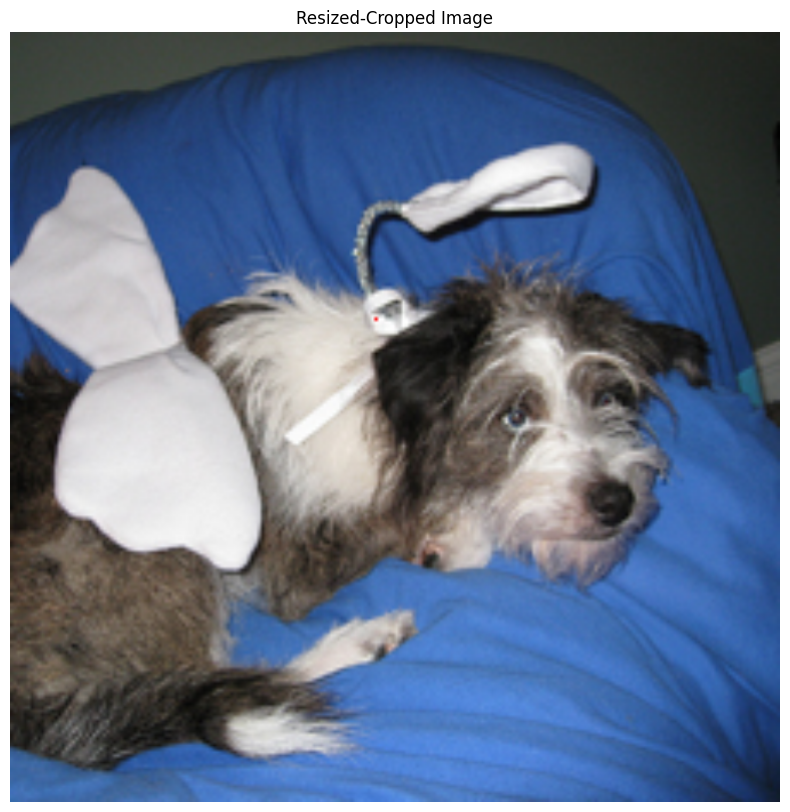

In [82]:
prompts = [gt_prompt] + prediction_prompts
colors = ['red' if i != 0 else 'green' for i in range(len(prompts))]
boxes = visualize_zero_shot_object_detection_boxes(sample_img, prompts, 'Raw Image')
_ = visualize_zero_shot_object_detection_boxes(clip_sample_img, prompts, 'Resized-Cropped Image')
plt.show()